## **Functional decomposition of a dataset**

To effectively utilise Gaussian processes, we must address their limitations in modelling high-dimensional datasets. We advise keeping the dimensionality to be less than 20 in each of the inputs and outputs for optimal performance. Additionally, training on lower-dimensional data allows one to save time and computational resources.

Twinlab employs dimensionality reduction techniques and provides users with the option to specify the number of dimensions, or the amount of variance they wish to retain, before training a model. These methods streamline the data, making it feasible to apply GPs on higher-dimensional datasets, even those with many hundreds or even thousands of input or output features.

This notebook will explain how to utilise the `analyse_variance`method on your dataset to make informed decisions about how to effectively process the dataset you wish to train.


In [1]:
# Standard import
import os

# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd

# twinLab import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.3.0
          Server      : https://mo1b0kfcp6.execute-api.eu-west-2.amazonaws.com/dev
          Environment : /Users/sergiochavez/twinlab-demos/.env



Dimensionality reduction works by using statistical techniques to find correlations between dimensions. It relies on the principle that highly-correlated variables contribute minimal aditional information and so the essential structure of a dataset can be captured in fewer dimensions. The variance retained per dimension directly indicates how much of the original variability of the dataset is preserved, offering insight into the amount of information that can be sumarised in each variable.

We will begin by showing how this works on a real dataset. We start by reading the dataset from a CSV file, converting this into a twinLab `Dataset` and updloading the data to the cloud.


In [2]:
# Reading in the data from CSV
data_path = os.path.join("resources", "datasets", "ukaea_small.csv")
df_train = pd.read_csv(data_path)

# Initialising and uploading a dataset
training_dataset = tl.Dataset("fusion_dataset")
training_dataset.upload(df_train)

# Defining the inputs and output variables
input_columns = ["E1", "E2", "E3", "n1", "n2"]
output_columns = [f"y{i}" for i in range(0, df_train.shape[1] - len(input_columns))]

The dataset contains datapoints with 5 input dimensions and 624 output dimensions! The number of output dimensions is particularly high and it might be better to train our emulators on truncated outputs for efficient and effective training. With that purpose, we can use `analyse_variance` to explore how many dimmensions we need to achieve a desired overall variance.


In [3]:
# Analyse variance in the input columns
input_variance_df = training_dataset.analyse_variance(columns=input_columns)
display("Input variance analysis", input_variance_df)

'Input variance analysis'

,Number of Dimensions,Cumulative Variance
0,0,0.000000
1,1,0.406099
2,2,0.813714
3,3,0.999969
4,4,0.999999
5,5,1.000000


In [4]:
# Analyse variance in the output columns
output_variance_df = training_dataset.analyse_variance(columns=output_columns)
display("Output variance analysis", output_variance_df)

'Output variance analysis'

,Number of Dimensions,Cumulative Variance
0,0,0.000000
1,1,0.265579
2,2,0.734992
3,3,0.895238
4,4,0.969070
...,...,...
396,396,1.000000
397,397,1.000000
398,398,1.000000
399,399,1.000000


It can be observed that only three dimensions can explain more than 99% of the variance in the case of inputs. For the outputs, the first four dimensions explain more than 95% of the total variance.

The results suggest that reducing the dimensions of the dataset would be very beneficial for the effectiveness of subsequent training using Gaussian processes. This is especially true for the outputs as they would go from having 624 dimensions to 6 while maintaining more than 99% of the variance explained.

The analysis can be seen more clearly in the following graphs.


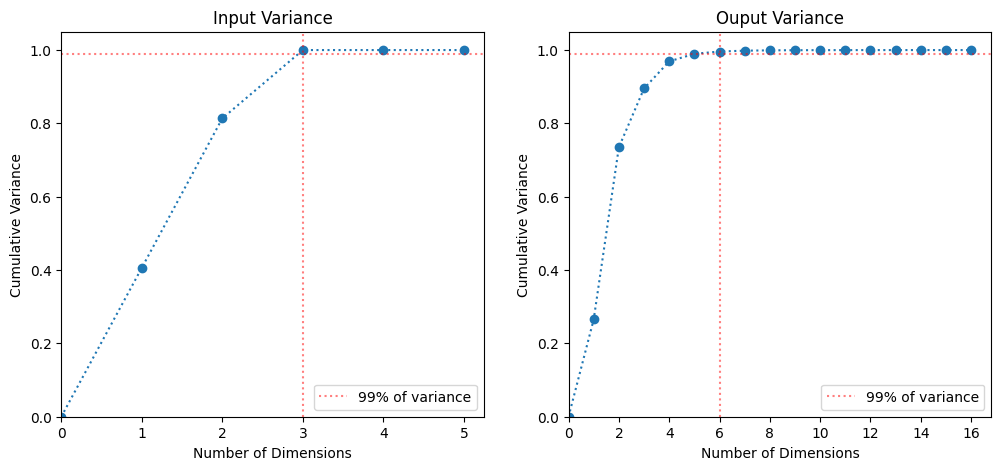

In [5]:
# Initialise plot
plt.subplots(1, 2, figsize=(12, 5))

# Plot the first dataframe on the left-hand plot
plt.subplot(1, 2, 1)
plt.title("Input Variance")  # , fontsize=20)
plt.plot(
    input_variance_df["Number of Dimensions"],
    input_variance_df["Cumulative Variance"],
    linestyle=":",
    marker="o",
)
plt.axvline(x=3, color="red", linestyle=":", alpha=0.5)
plt.axhline(0.99, color="red", linestyle=":", alpha=0.5, label="99% of variance")
plt.xlabel("Number of Dimensions")
plt.xlim(left=0.0)
plt.ylabel("Cumulative Variance")
plt.ylim(0.0, 1.05)
plt.legend()

# Plot the second dataframe on the right-hand plot
plt.subplot(1, 2, 2)
plt.title("Ouput Variance")  # , fontsize=20)
plt.plot(
    output_variance_df["Number of Dimensions"][:17],
    output_variance_df["Cumulative Variance"][:17],
    linestyle=":",
    marker="o",
)
plt.axvline(x=6, color="red", linestyle=":", alpha=0.5)
plt.axhline(0.99, color="red", linestyle=":", alpha=0.5, label="99% of variance")
plt.xlabel("Number of Dimensions")
plt.xlim(left=0.0)
plt.ylabel("Cumulative Variance")
plt.ylim(0.0, 1.05)
plt.legend()

plt.show()

As discussed, the plots show how most of the variance (99%) can be captured with a much lower dimensional dataset for both the input (3 dimensions) and the output (6 dimensions).
